### Exploring Scikit-learn Decision Tree Classifier

In [1]:
# importing libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

# for visualisation

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call

print("modules imported")

modules imported


In [2]:
# functions

def import_data(path):
    """
    Imports csv from inputted path
    
    Parameters:
    - path: str, the location of the data
    
    Returns:
    - data: dataframe object
    """
    data = pd.read_csv(path)
    return data

def split_data(data, X_cols, y_col):
    """
    Split the data into features (X) and labels (y) based on column positions.
    
    Parameters:
    - data: DataFrame, the dataset containing the data
    - X_cols: list of integers, column positions for features X
    - y_col: integer, column position for the label y
    
    Returns:
    - X: array-like, features
    - y: array-like, labels
    """
    X = data.iloc[:, X_cols].values
    y = data.iloc[:, y_col].values
    return X, y

def print_missing_values_count(data):
    """
    Print the count of missing values in every column of the DataFrame.
    
    Parameters:
    - data: DataFrame, the dataset containing the data
    """
    missing_values_count = data.isnull().sum()
    print(missing_values_count)
    
def get_column_names(data, column_positions):
    """
    Get the names of columns based on their positions.
    
    Parameters:
    - data: DataFrame, the dataset containing the data
    - column_positions: list of integers, column positions for which to get names
    
    Returns:
    - list of strings, names of columns based on their positions
    """
    column_names = data.columns
    columns_to_use = [column_names[pos] for pos in column_positions]
    return columns_to_use

# paths

data_path = "titanic.csv"

# features and labels; position(s) in dataframe

features = [2,4,5,9]
labels = 1

# other parameters

r = 5

In [3]:
# loading and inspecting the data

data = import_data(data_path)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# data cleaning specific to Titanic data

data['Sex'] = data['Sex'].apply(lambda x: 0 if x == 'female' else 1)
data.dropna(subset=['Age'], inplace=True)

# check for missing values post-data cleaning

print_missing_values_count(data)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          529
Embarked         2
dtype: int64


In [5]:
# defining features and labels

X, y = split_data(data, features, labels)

# Split the data into 75% training and 25% combined for development and testing

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=r)

# Split the temp data into development (50%) and test (50%)

X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=r)

In [6]:
# training a model without pruning

unpruned = DecisionTreeClassifier(max_depth=None, random_state=r)
unpruned.fit(X_train, y_train)

print("Performance without pruning:", unpruned.score(X_dev, y_dev))
print("At depth:", unpruned.tree_.max_depth)

Performance without pruning: 0.7415730337078652
At depth: 19


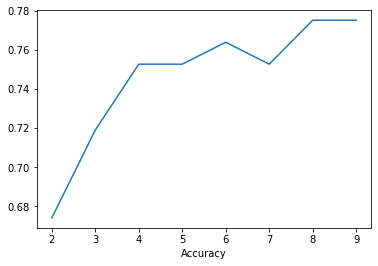

In [7]:
# looking at effect of pruning   

pruned_depths = range(2,10)

pruned_scores = [] 
for d in pruned_depths:
    
    clf = DecisionTreeClassifier(max_depth=d, random_state=r)
    clf.fit(X_train, y_train)
    score = clf.score(X_dev, y_dev)
    pruned_scores.append(score)

fig, ax = plt.subplots()
ax.plot(pruned_depths, pruned_scores)
plt.xlabel("Max_depth values")
plt.xlabel("Accuracy")
ax.xaxis.set_ticks(pruned_depths)
plt.show()

In [8]:
# fitting the chosen tree
best_depth = pruned_depths[np.argmax(pruned_scores)]
print('Best performance reached at depth of:', best_depth)

pruned = DecisionTreeClassifier(max_depth=(best_depth-3))
pruned.fit(X_train, y_train)

Best performance reached at depth of: 8


DecisionTreeClassifier(max_depth=5)

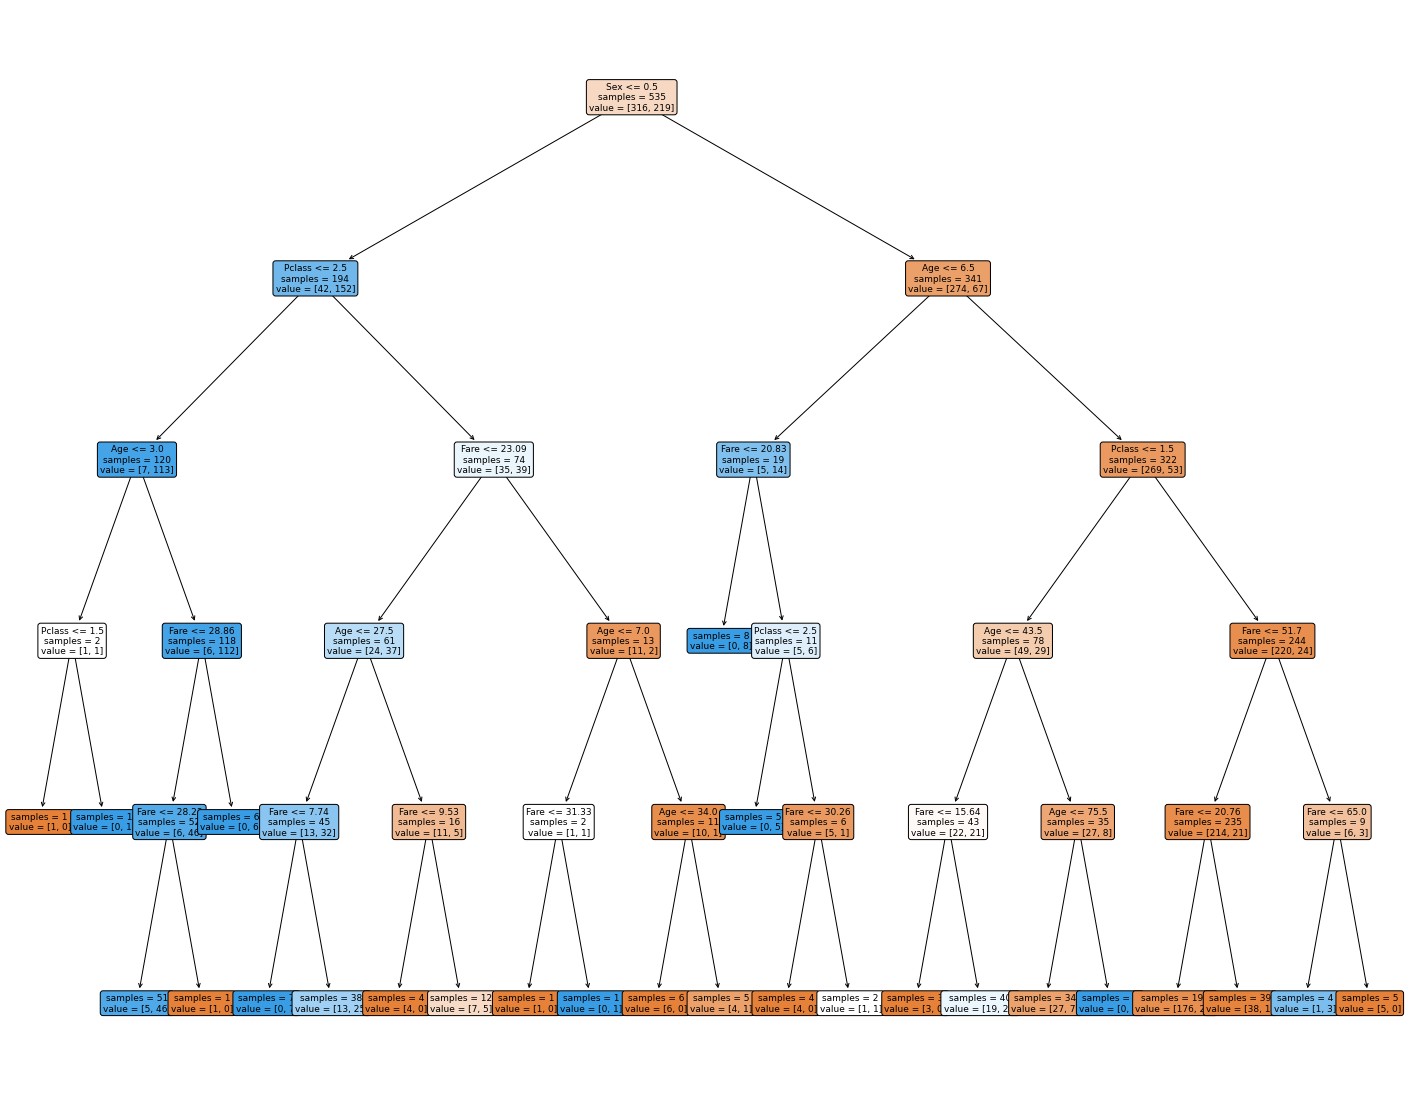

In [9]:
# visualising the tree

columns_for_visual = get_column_names(data, features)
graphviz_installed = False

if (graphviz_installed):
    
    export_graphviz(pruned, out_file='pruned_tree.dot', feature_names = iris.feature_names,
                  rounded = True, proportion = False, precision = 2, filled = True)
  
  # Convert to png using system command
    call(['dot', '-Tpng', 'pruned_tree.dot', '-o', 'pruned_tree.png', '-Gdpi=600'])

else: 
     
    #fig = plt.figure()
    font_size = 9
    fig, ax = plt.subplots(figsize=(25, 20))
    tree.plot_tree(pruned,feature_names = columns_for_visual, 
                   rounded = True, proportion = False, 
                   precision = 2, filled = True, fontsize=font_size, 
                   ax=ax, impurity=False)
    fig.savefig('pruned_tree.png', dpi=800)

    
# Image(filename = 'pruned_tree.png', width=400) #uncomment if using graphviz

# interpreting the visual:

# value represents the survived column; 0 (did not) or 1 (did survive)
# sex: 0 == female; 1 == male



In [10]:
# Evaluate the pruned model on the test set

pruned_accuracy = pruned.score(X_test, y_test)
print("Accuracy of the pruned decision tree on the test set:", pruned_accuracy)


Accuracy of the pruned decision tree on the test set: 0.8333333333333334


In [11]:
# exploring effects of Bagging

ensemble = BaggingClassifier(base_estimator=pruned, n_estimators=100, random_state=7)
ensemble.fit(X_train,y_train)
print("Accuracy of the ensemble / bagged model on the test set:",ensemble.score(X_test, y_test))

Accuracy ensemble: 0.8333333333333334


In [12]:
# exploring effects of Random Forest approach

forest = RandomForestClassifier(n_estimators=100, random_state=7)
forest.fit(X_train, y_train)
print("Accuracy of the Random Forest on the test set:",forest.score(X_test, y_test))

Accuracy of the Random Forest on the test set: 0.8111111111111111


In [13]:
# examining importance scores to see which features have most predictive power in the Random Forest 

feature_imp = pd.Series(forest.feature_importances_).sort_values(ascending=False)
feature_imp

2    0.318210
3    0.299706
1    0.298010
0    0.084074
dtype: float64